<a href="https://colab.research.google.com/github/ryanmdpeters21/Data-Analysis/blob/main/Football_Analytics_with_Python_chap3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install nfl_data_py
!pip install numpy
!pip install nfl_data_py
!pip install statsmodels
!pip install matplotlib
!pip install seaborn

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.9 MB/s eta 0:00:00
  Created wheel for nfl_data_py: filename=nfl_data_py-0.3.1-py3-none-any.whl size=13187 sha256=c32cc636a0c45dca3d2fb137794ec885e1f57dd92ddb820e886ae893f478f6ae
  Stored in directory: /root/.cache/pip/wheels/ca/2e/d2/4def312ac7c070e1c0002e91ecc6923481a86c3ebd5b2c5413
Successfully built nfl_data_py


In [3]:
 # We want to make a simple linear regression model that will calculate Rushing Yards Over Expected (RYOE)
 # This model will take into account various facotrs that affect a play's success

In [4]:
# We will start as always by importing our libraries.
import pandas as pd
import numpy as np
import nfl_data_py as nfl
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# we can now load in our data
seasons = range(2016, 2022+1)
pbp_py = nfl.import_pbp_data(seasons)

2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
Downcasting floats.


In [6]:
# Now let's select rushing plays.
# We use filter criteria "run" and remove plays w/o rushers.

pbp_py_run =\
  pbp_py.query('play_type == "run" & rusher_id.notnull()')\
  .reset_index()
pbp_py_run\
  .loc[pbp_py_run.rushing_yards.isnull(), 'rushing_yards'] = 0

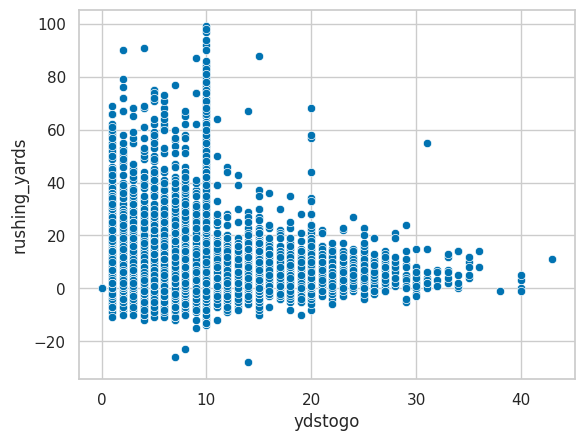

In [7]:
# Now we can plot our data using displot().
sns.set_theme(style="whitegrid", palette="colorblind")
sns.scatterplot(data=pbp_py_run, x='ydstogo', y='rushing_yards');
plt.show();

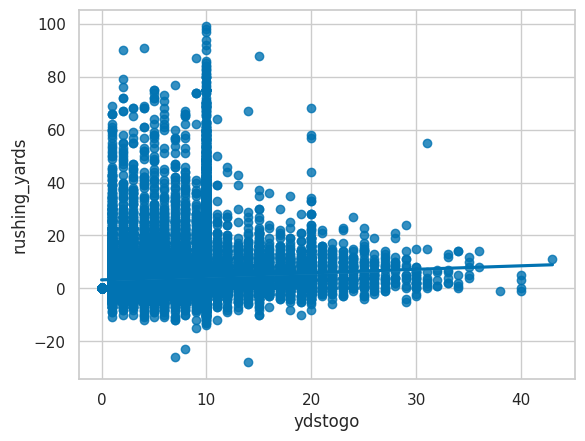

In [8]:
# Let's try adding a trendline to our graph.
# We can using .regplot() for this.
sns.regplot(data=pbp_py_run, x='ydstogo', y='rushing_yards');
plt.show()

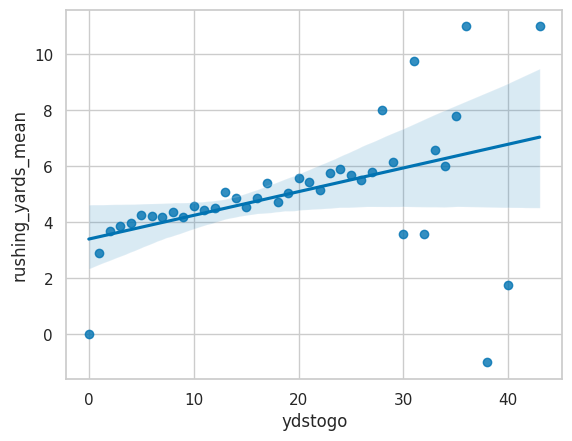

In [9]:
# Let's try w/ binning & averaging.
# It gives us a good idea of whether it is worth investigating a linear relationship.
pbp_py_run_ave =\
  pbp_py_run.groupby(['ydstogo'])\
  .agg({'rushing_yards': ['mean']})

pbp_py_run_ave.columns = \
  list(map('_'.join, pbp_py_run_ave.columns))
pbp_py_run_ave\
  .reset_index(inplace=True)

sns.regplot(data=pbp_py_run_ave, x='ydstogo', y='rushing_yards_mean');
plt.show()

In [10]:
# Now let's build our model.
import statsmodels.formula.api as smf

yard_to_go_py =\
  smf.ols(formula='rushing_yards ~ 1 + ydstogo', data=pbp_py_run)

print(yard_to_go_py.fit().summary())

                            OLS Regression Results                            
Dep. Variable:          rushing_yards   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     623.7
Date:                Thu, 04 Jan 2024   Prob (F-statistic):          3.34e-137
Time:                        01:51:14   Log-Likelihood:            -3.0107e+05
No. Observations:               92425   AIC:                         6.021e+05
Df Residuals:                   92423   BIC:                         6.022e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.2188      0.047     68.142      0.0

In [11]:
# Let's create a new column called 'RYOE' in pbp_py_run from our earlier model's residuals.
pbp_py_run['ryoe'] =\
  yard_to_go_py\
  .fit()\
  .resid

In [12]:
# Let's look at the leaderboard for RYOE from '16 to '22.
# The count of RYOE is the number of carries a rusher has.
# The sum of RYOE is the total RYOE.
# The mean of RYOE is the RYOE per carry.
# The mean of rushing yards is the yards per carry.
ryoe_py =\
  pbp_py_run\
  .groupby(['season', 'rusher_id', 'rusher'])\
  .agg({
      'ryoe': ['count', 'sum', 'mean'],
      'rushing_yards': 'mean'})

ryoe_py.columns = \
  list(map('_'.join, ryoe_py.columns))
ryoe_py.reset_index(inplace=True)

ryoe_py =\
  ryoe_py\
  .rename(columns={
      'ryoe_count': 'n',
      'ryoe_sum': 'ryoe_total',
      'ryoe_mean': 'ryoe_per',
      'rushing_yards_mean': 'yards_per_carry',
  }
).query('n > 50')

print(ryoe_py.sort_values('ryoe_total', ascending=False))

      season   rusher_id     rusher    n  ryoe_total  ryoe_per  \
1989    2021  00-0036223   J.Taylor  332  417.501295  1.257534   
1440    2020  00-0032764    D.Henry  397  362.768406  0.913774   
1258    2019  00-0034796  L.Jackson  135  353.652105  2.619645   
1143    2019  00-0032764    D.Henry  387  323.921354  0.837006   
1474    2020  00-0033293    A.Jones  222  288.358241  1.298911   
...      ...         ...        ...  ...         ...       ...   
419     2017  00-0029613   D.Martin  139 -198.461432 -1.427780   
122     2016  00-0029613   D.Martin  144 -199.156646 -1.383032   
675     2018  00-0027325   L.Blount  155 -247.528360 -1.596957   
1058    2019  00-0030496     L.Bell  245 -286.996618 -1.171415   
267     2016  00-0032241   T.Gurley  278 -319.803875 -1.150374   

      yards_per_carry  
1989         5.454819  
1440         5.206549  
1258         6.800000  
1143         5.131783  
1474         5.540541  
...               ...  
419          2.920863  
122          2.

In [13]:
print(ryoe_py.query('n > 50').sort_values('ryoe_per', ascending=False).to_string())

      season   rusher_id             rusher    n  ryoe_total  ryoe_per  yards_per_carry
2235    2022  00-0034796          L.Jackson   73  275.839751  3.778627         7.821918
1258    2019  00-0034796          L.Jackson  135  353.652105  2.619645         6.800000
1286    2019  00-0035228           K.Murray   56  121.698571  2.173189         6.500000
1560    2020  00-0034796          L.Jackson  121  249.477338  2.061796         6.264463
1897    2021  00-0034750            R.Penny  119  229.243077  1.926412         6.294117
2377    2022  00-0036945           J.Fields   85  159.605741  1.877715         6.000000
2165    2022  00-0033357             T.Hill   96  178.171063  1.855949         5.989583
1870    2021  00-0034253         D.Hilliard   56  100.656428  1.797436         6.250000
2229    2022  00-0034750            R.Penny   57   99.151099  1.739493         6.070176
1236    2019  00-0034400          J.Wilkins   51   87.834539  1.722246         6.019608
376     2017  00-0027939        

In [14]:
# Let's make our LRM
# Start by keeping only used columns.
cols_keep =['season', 'rusher_id', 'rusher', 'ryoe_per', 'yards_per_carry']

# We can  create the current df.
ryoe_now_py = ryoe_py[cols_keep].copy()

# We can now create last year's df.
ryoe_last_py = ryoe_py[cols_keep].copy()

# Rename the columns.
ryoe_last_py\
  .rename(columns = {'ryoe_per': 'ryoe_per_last',
                     'yards_per_carry': 'yards_per_carry_last'},
                      inplace=True)

# We can add 1 to season.
ryoe_last_py['season'] += 1

# Merge together.
ryoe_lag_py = ryoe_now_py.merge(ryoe_last_py,
                                how='inner',
                                on=['rusher_id', 'rusher',
                                    'season'])

# Let's examine the correlation for yards per carry.
ryoe_lag_py[['yards_per_carry_last', 'yards_per_carry']].corr()

,yards_per_carry_last,yards_per_carry
yards_per_carry_last,1.00000,0.32261
yards_per_carry,0.32261,1.00000


In [15]:
# Let's examine the correlation for RYOE.
ryoe_lag_py[['ryoe_per_last', 'ryoe_per']].corr()

,ryoe_per_last,ryoe_per
ryoe_per_last,1.000000,0.348923
ryoe_per,0.348923,1.000000
